## Decision Trees
---

We are going to try and see if we can predict delay from our flight delay + weather dataset. Since decision trees are suitable for categorical variables and continuous variables, we will make a prediction of a continous variable. Meaning that we will use a regression based version of decisions trees. 

**Let's grab the merged dataset that we are going to use**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [3]:
data_path = os.path.join('..','data','flights_weather.csv')

# read the dataset into a dataframe (car)
# there are some columns which get read in as the wrong datatype,
# so we want to keep them as strings
dtypes = {
    'ORIGIN_AIRPORT': 'str', 
    'DESTINATION_AIRPORT': 'str', 
    'IATA_CODE_x': 'str', 
    'origin_weather_station': 'str', 
    'IATA_CODE_y': 'str', 
    'destination_weather_station': 'str', 
    'OR_MAX': 'str', 
    'OR_MIN': 'str', 
    'OR_PRCP': 'str', 
    'DES_MAX': 'str', 
    'DES_MIN': 'str', 
    'DES_PRCP': 'str', 
    'OR_FRSHTT': 'str', 
    'DES_FRSHTT': 'str'
}
fw_df = pd.read_csv(data_path, dtype=dtypes, parse_dates=['DATE'])

In [4]:
fw_df.head()

,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,...,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,...,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,010000
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,...,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,000000
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,...,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,000000
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,...,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000


### Let's clean things up a little bit
---
Let's get rid of the Unnamed column and add a new column called label which labels each as delayed
or not.

In [4]:
fw_df.drop('Unnamed: 0', axis=1, inplace=True)
fw_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,000000
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,010000
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,000000
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,000000
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000


In [5]:
fw_df.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
                        ...   
OR_VISIB               float64
OR_COUNT


### We've got a lot of variables!
---
There is 75 columns, there. Let's create a correlation heatmap and use that
to select some strongly correlated variables, with which we can produce a 
pair plot to get a little more insight into interesting variable.
This way we can try to intelligently choose the variables to use as features for our decision tree model.

In [6]:
# get the correlation of the dataset
corr = fw_df.corr()

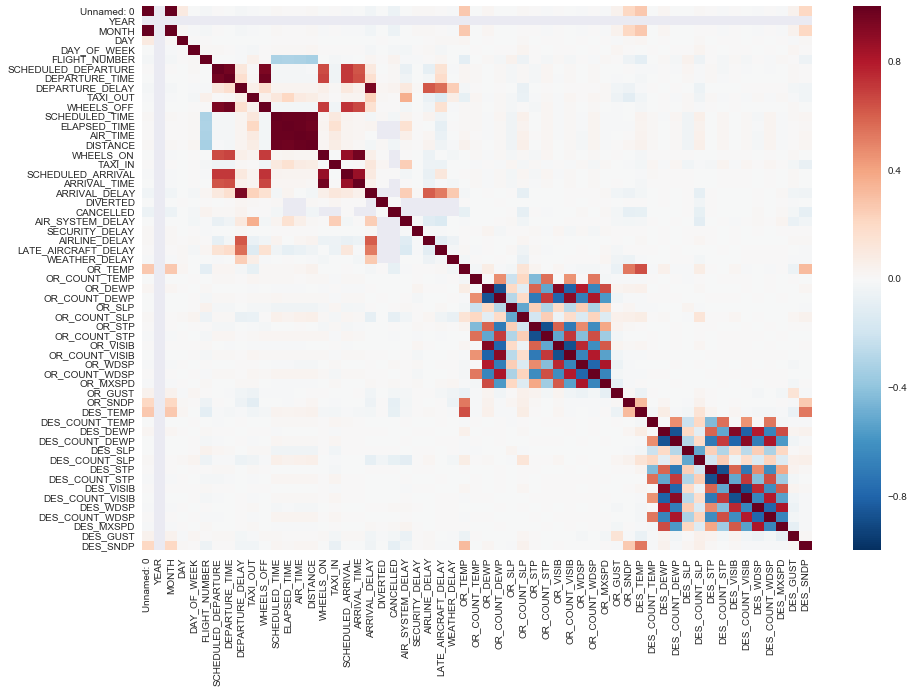

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax
)

It's a little difficult to get anything too interesting. We can see that it seems like our target
variable of DEPARTURE_DELAY, doesn't correlate strongly with any weather related variables. Which
is mostly what we want to look at. We can also try looking at DEPARTURE_DELAY vs SCHEDULED_DEPARTURE.

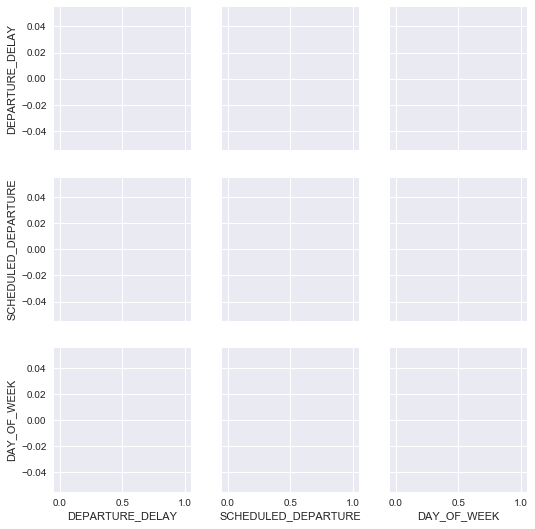

In [10]:
# create a pair plot from the dataset
#v = fw_df.columns.values
v=['DEPARTURE_DELAY','SCHEDULED_DEPARTURE','DAY_OF_WEEK']
sns.pairplot(fw_df.dropna(), vars=v)